In [1]:
p=0.4

import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k
    

In [2]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [3]:

from qiskit_algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

from qiskit.primitives import Sampler

sampler = Sampler()

C:\Users\Rajat\AppData\Local\Temp\ipykernel_4744\1355126011.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [15]:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
service=QiskitRuntimeService()

In [4]:
from qiskit_algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

In [6]:
ae_result = ae.estimate(problem)
print(ae_result.estimation)

0.5


In [21]:
import matplotlib.pyplot as plt

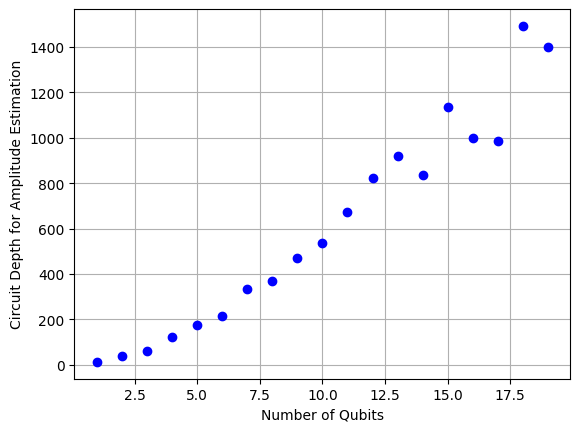

In [25]:
def construct_ae(n):
    global backend
    p=0.2
    global A,Q
    problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    ae = AmplitudeEstimation(
    num_eval_qubits=n,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
    )
    ae_circuit = ae.construct_circuit(problem)

    pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

    isa_circ=pm.run(ae_circuit)

    return isa_circ.depth()
for i in range (1,20):
    plt.plot(i,construct_ae(i),"bo-")
plt.grid(True)
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth for Amplitude Estimation")
plt.show()

In [7]:
print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.39999999835285005


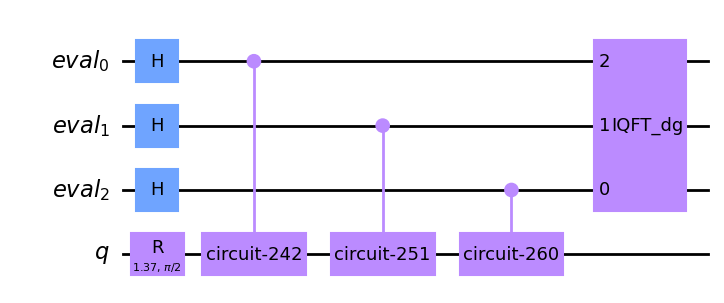

In [8]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="clifford"
)

In [12]:
backend=service.least_busy(operational=True)
print(backend.name)

ibm_brisbane


In [13]:
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

isa_circ=pm.run(ae_circuit)

Circuit Depth for ISA Circuit: 69


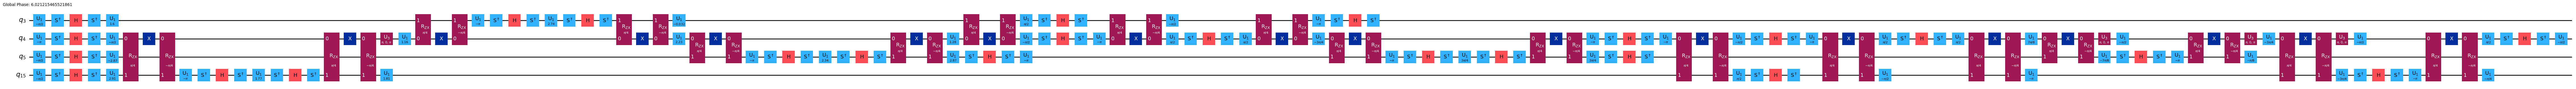

In [14]:
print(f"Circuit Depth for ISA Circuit: {isa_circ.depth()}")
isa_circ.decompose().draw(output="mpl",idle_wires=False,fold=-1)

In [26]:
from qiskit_algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.4


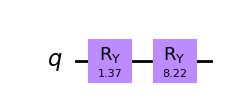

In [27]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="clifford")

In [28]:
def construct_iae(k):
    global backend
    p=0.2
    global A,Q
    problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
    )
    iae_circuit = iae.construct_circuit(problem, k=k)

    pm=generate_preset_pass_manager(backend=backend,optimization_level=3)
    isa_circ=pm.run(iae_circuit)
    return isa_circ.depth()


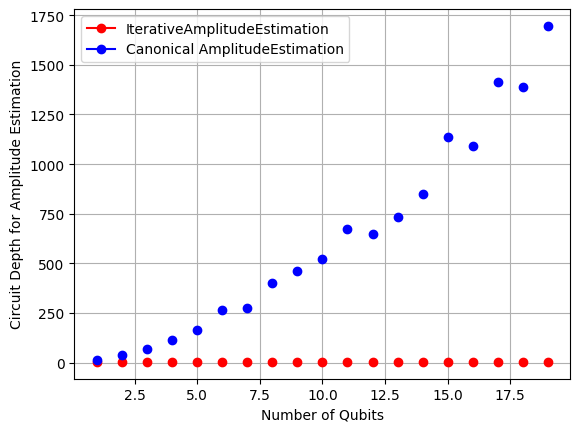

In [35]:
for i in range (1,20):
    plt.plot(i,construct_iae(i),"ro-")
    plt.plot(i,construct_ae(i),"bo-")
plt.grid(True)
plt.xlabel("Number of Qubits")
plt.legend(["IterativeAmplitudeEstimation","Canonical AmplitudeEstimation"])
plt.ylabel("Circuit Depth for Amplitude Estimation")
plt.show()

Derivative Pricing Circuit

In [2]:
import numpy as np

# import the necessary parts of Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit import Gate
from qiskit.circuit.library import QFT

In [3]:
P = Gate(name='P', num_qubits=1, params=[], label=None)

# Preapres payoff function corresponding to derivative
F = Gate(name='F', num_qubits=2, params=[], label=None)

In [4]:
reg = QuantumRegister(2)
circ = QuantumCircuit(reg, name='Q')
# This next line is arbitrary
# Any 2-qubit gate will do
circ.cx(reg[0], reg[1])
Q = circ.to_gate()
Q.name = 'Q'
cQ = Q.control(1)
Q.name = 'Q2'
cQ2 = Q.control(1)
Q.name = 'Q4'
cQ4 = Q.control(1)
Q.name = 'Q8'
cQ8 = Q.control(1)

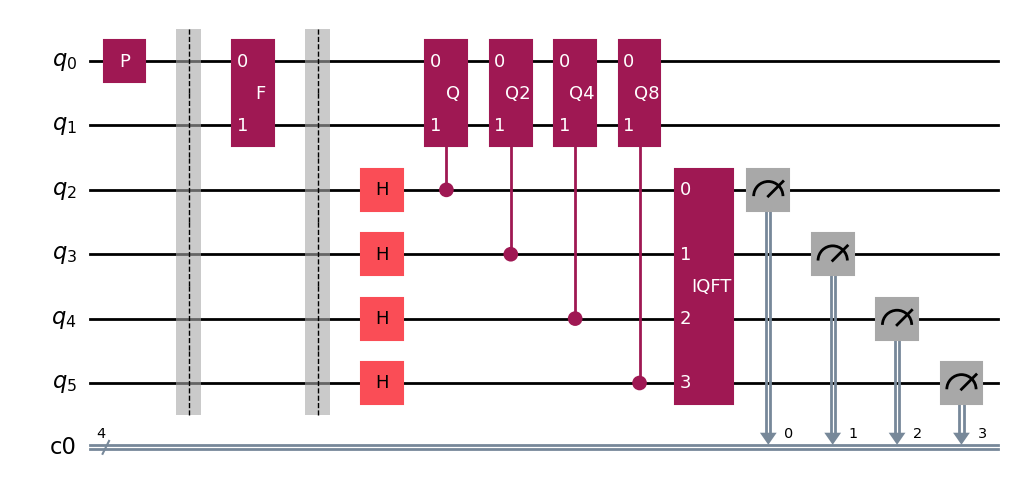

In [5]:
# Create final circuit
reg = QuantumRegister(6, name='q')
creg = ClassicalRegister(4)
circ = QuantumCircuit(reg, creg, name='Q')

# Stage 1
# Prepare probability distribution
circ.append(P, (reg[0],))
circ.barrier()

# Stage 2
# Prepare derivative payoff
circ.append(F, (reg[0], reg[1]))
circ.barrier()

# Stage 3
# PEA
circ.h(reg[2])
circ.h(reg[3])
circ.h(reg[4])
circ.h(reg[5])
circ.append(cQ, (reg[2], reg[0], reg[1]))
circ.append(cQ2, (reg[3], reg[0], reg[1]))
circ.append(cQ4, (reg[4], reg[0], reg[1]))
circ.append(cQ8, (reg[5], reg[0], reg[1]))
circ.append(QFT(num_qubits=4, inverse=True), [reg[i+2] for i in range(4)])
circ.measure(reg[2], creg[0])
circ.measure(reg[3], creg[1])
circ.measure(reg[4], creg[2])
circ.measure(reg[5], creg[3])
circ.draw("mpl")

In [58]:
isa_circ=pm.run(circ)
print(isa_circ.depth())

1996


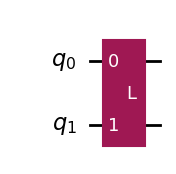

In [8]:
reg = QuantumRegister(2, name='q')
circ = QuantumCircuit(reg, name='L')
circ.h(reg[0])
circ.cx(reg[0], reg[1])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
L = circ.to_gate()

# Build the circuit
reg = QuantumRegister(2, name='q')
circ = QuantumCircuit(reg, name='L')
circ.append(L, (reg[0], reg[1]))

circ.draw(output="mpl")

In [9]:
u = (1/np.sqrt(2))*np.array([1,0,0,1])
# We build P1 = |1><1|
a = np.array([0,1])
aT = np.transpose(a)
# P=|1><1| 
P1 = np.outer(aT,a)
# Op = I_2 \bigotimes |1><1|
Op = np.kron(P1, np.eye(2))
#u = np.transpose(ch_ket)
u = np.dot(u, np.dot(Op, u))
print("u = {0}".format(np.round(u,2)))
r = 1/4.
print("V_0 = {0}".format(1/(1+r)*3*u))

u = 0.5
V_0 = 1.2


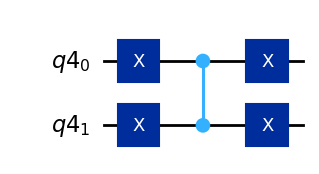

In [11]:
reg = QuantumRegister(2)
circ = QuantumCircuit(reg, name='Z')
circ.x(reg[0])
circ.x(reg[1])
circ.cz(reg[0], reg[1])
circ.x(reg[0])
circ.x(reg[1])
# Convert to a gate and stick it into an arbitrary place in the bigger circuit
Z = circ.to_gate()
circ.draw(output="mpl")

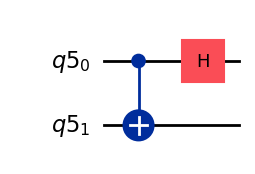

In [12]:
reg = QuantumRegister(2)
circ = QuantumCircuit(reg, name='L_adj')
circ.cx(reg[0], reg[1])
circ.h(reg[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
Ladj = circ.to_gate()
circ.draw(output="mpl")

In [13]:
reg = QuantumRegister(2)
circ = QuantumCircuit(reg, name='U')
circ.z(reg[1])
print(circ)
# Convert to a gate and stick it into an arbitrary place in the bigger circuit
U = circ.to_gate()

           
q6_0: ─────
      ┌───┐
q6_1: ┤ Z ├
      └───┘


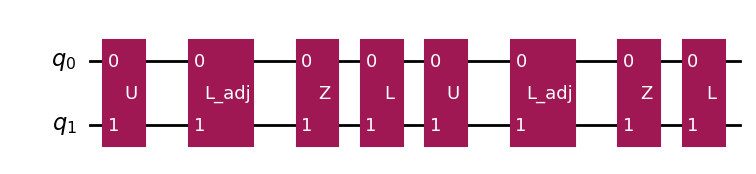

In [14]:
reg = QuantumRegister(size=2, name='q')
circ = QuantumCircuit(reg, name='Q')
circ.append(U, [reg[0], reg[1]])
circ.append(Ladj, [reg[0], reg[1]])
circ.append(Z, [reg[0], reg[1]])
circ.append(L, [reg[0], reg[1]])
circ.append(U, [reg[0], reg[1]])
circ.append(Ladj, [reg[0], reg[1]])
circ.append(Z, [reg[0], reg[1]])
circ.append(L, [reg[0], reg[1]])
circ.draw(output="mpl")

     ┌────┐
q_0: ┤0   ├
     │  Q │
q_1: ┤1   ├
     └────┘


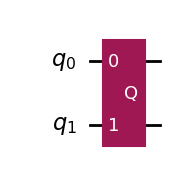

In [15]:
Q = circ.to_gate()
reg = QuantumRegister(2, name='q')
circ = QuantumCircuit(reg, name='Q')
circ.append(Q, [reg[0], reg[1]])
print(circ)
circ.draw(output='mpl')

In [17]:

reg = QuantumRegister(3)
circ = QuantumCircuit(reg, name='Q')
cQ = Q.control(1)
circ.append(cQ, [reg[2], reg[0], reg[1]])
circ.draw()
# Let's keep track of the controlled-Qs
cQs = {}
cQs[2**0] = cQ

reg = QuantumRegister(3)
circ = QuantumCircuit(reg, name='cQ')
circ.append(cQ, [reg[2], reg[0], reg[1]])
print(circ)

       ┌────┐
q14_0: ┤0   ├
       │  Q │
q14_1: ┤1   ├
       └─┬──┘
q14_2: ──■───
             


In [18]:
n_b = 3
for i in range(1,n_b):
    reg = QuantumRegister(2)
    circ = QuantumCircuit(reg, name='Q{0}'.format(int(2**i)))
    for _ in range(2**i):
        circ.append(Q, [reg[0], reg[1]])
    Q2i = circ.to_gate()
    cQ2i = Q2i.control(1)
    cQs[2**i] = cQ2i
    reg = QuantumRegister(3)
    circ = QuantumCircuit(reg, name='cQ{0}'.format(int(2**i)))
    circ.append(cQ2i, [reg[2], reg[0], reg[1]])
    print(circ)

       ┌─────┐
q21_0: ┤0    ├
       │  Q2 │
q21_1: ┤1    ├
       └──┬──┘
q21_2: ───■───
              
       ┌─────┐
q28_0: ┤0    ├
       │  Q4 │
q28_1: ┤1    ├
       └──┬──┘
q28_2: ───■───
              


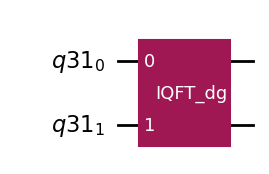

In [21]:
reg = QuantumRegister(2)
circ =  QuantumCircuit(reg, name='test')
circ.append(QFT(num_qubits=2, inverse=True), [reg[i] for i in range(2)])
circ.decompose().draw(output="mpl")

In [40]:

def construct(a,b):
    n_w=2**a 
    n_b=b
    n=n_w+1+n_b 
    reg = QuantumRegister(n)
    c = ClassicalRegister(n_b)
    circ = QuantumCircuit(reg, c, name='Derivative pricing')

# Apply F
    circ.append(L, [reg[0], reg[1]])

# Hadamards
    for _ in range(n_w+1, n):
      circ.h(reg[_])
    
# Controlled Qs
    for _ in range(n_b):
     circ.append(cQs[2**_], [reg[n_w+1+_], reg[0], reg[1]])
    
# Inverse QFT
    circ.append(QFT(num_qubits=n_b, inverse=True), [reg[i] for i in range(n_w+1,n)])
    for _ in range(n_w+1, n):
      circ.measure(reg[_], c[_-n_w-1])
    return circ



In [44]:
pm=generate_preset_pass_manager(optimization_level=3,backend=backend)

In [47]:
depth_ae=[]
qubits=[]
for i in range (2,5):
    qc=construct(0,i) 
    qubits.append(i) 
    isa_circ=pm.run(qc)
    depth_ae.append(isa_circ.depth())
plt.plot(qubits,depth_ae,label="Amplitude Estimation")
plt.legend()
plt.xlabel("Number of Qubits")
plt.ylabel("Circuit Depth for ISA")
plt.title(f"Circuit Depth for Transpilation in: {backend.name}")
plt.grid(True)
plt.show()


KeyError: 8

In [35]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
from qiskit_ibm_runtime import QiskitRuntimeService 

service=QiskitRuntimeService()
backend=service.least_busy(operational=True)

print(backend.name)

ibm_brisbane


In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

OrderedDict([('rz', 615), ('sx', 378), ('ecr', 182), ('x', 17)])
OrderedDict([('rz', 607), ('sx', 374), ('ecr', 180), ('x', 16)])
OrderedDict([('rz', 584), ('sx', 346), ('ecr', 175), ('x', 20)])
OrderedDict([('rz', 607), ('sx', 375), ('ecr', 175), ('x', 20)])
OrderedDict([('rz', 586), ('sx', 346), ('ecr', 177), ('x', 20)])
OrderedDict([('rz', 590), ('sx', 350), ('ecr', 178), ('x', 21)])


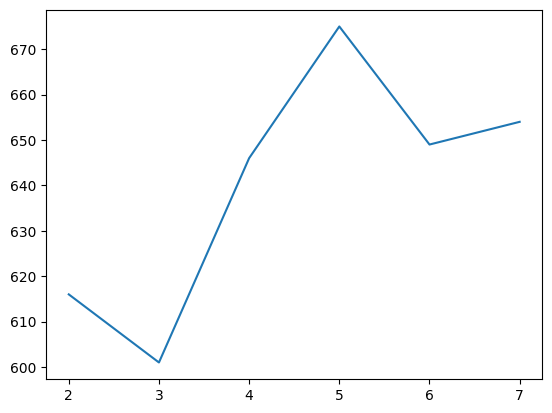

In [57]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import LinearAmplitudeFunction
def find_european_depth(num):
    num_uncertainty_qubits = 3

    # Parameters for considered random distribution
    S = 2.0  # initial spot price
    vol = 0.4  # volatility of 40%
    r = 0.05  # annual interest rate of 5%
    T = 40 / 365  # 40 days to maturity

    # Resulting parameters for log-normal distribution
    mu = (r - 0.5 * vol**2) * T + np.log(S)
    sigma = vol * np.sqrt(T)
    mean = np.exp(mu + sigma**2 / 2)
    variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    stddev = np.sqrt(variance)

    # Lowest and highest value considered for the spot price
    low = np.maximum(0, mean - 3 * stddev)
    high = mean + 3 * stddev

    # Construct A operator for QAE for the payoff function by
    # composing the uncertainty model and the objective
    uncertainty_model = LogNormalDistribution(
        num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
    )

    # Set the approximation scaling for the payoff function
    c_approx = 0.25

    # Setup piecewise linear objective function
    strike_price = 1.896  # Example strike price
    breakpoints = [low, strike_price]
    slopes = [0, 1]
    offsets = [0, 0]
    f_min = 0
    f_max = high - strike_price

    european_call_objective = LinearAmplitudeFunction(
        num_uncertainty_qubits,
        slopes,
        offsets,
        domain=(low, high),
        image=(f_min, f_max),
        breakpoints=breakpoints,
        rescaling_factor=c_approx,
    )

    # Construct A operator for QAE for the payoff function
    num_qubits = european_call_objective.num_qubits
    european_call = QuantumCircuit(num_qubits)
    european_call.append(uncertainty_model, range(num_uncertainty_qubits))
    european_call.append(european_call_objective, range(num_qubits))

    # Return the depth of the quantum circuit
    return european_call

# Example usage
depth_european=[]
qubits=[]
for i in range (2,8):
    qubits.append(i)
    isa_circ=pm.run(find_european_depth(i))
    depth_european.append(isa_circ.depth())
    print(isa_circ.count_ops())

plt.plot(qubits,depth_european)
plt.show()


In [ ]:
pm=generate_preset_pass_manager(optimization_level=3,backend=backend)
for i in range (2,8):
    

In [27]:
from qiskit_aer import QasmSimulator

In [28]:
sim=QasmSimulator()
compiled=transpile(circ,backend=sim)
pubs=sim.run(compiled,shots=1024)

result=pubs.result()
counts=result.get_counts()

print(counts)

{'100': 1024}


In [29]:
from qiskit.circuit.library import Diagonal

num_qubits = 3  # Number of qubits for the log-returns
S0 = 100  # Initial asset price
K = 105  # Strike price
fmax = S0 * np.exp(2) - K  # Max possible payoff (based on chosen discretization)
N = 2**num_qubits 

In [30]:
from scipy.special import eval_chebyt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution

In [3]:
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol ** 2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma ** 2, bounds=(low, high))

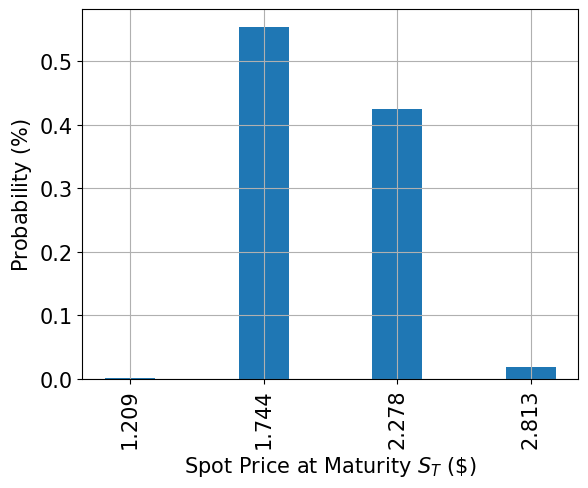

In [4]:
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [5]:
print("For intitial spot price", S, "these are the values and probability distributions:")
for i in 0,1,2,3:
    print("Value", x[i], "Probability", y[i]*100, "%")
   

For intitial spot price 2.0 these are the values and probability distributions:
Value 1.208607238741425 Probability 0.10573576926547217 %
Value 1.743528401859603 Probability 55.432593115910755 %
Value 2.2784495649777803 Probability 42.51986173075732 %
Value 2.813370728095958 Probability 1.9418093840664512 %


In [6]:
from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import LogNormalDistribution

import numpy as np
import matplotlib.pyplot as plt

In [7]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.05  # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high)
)

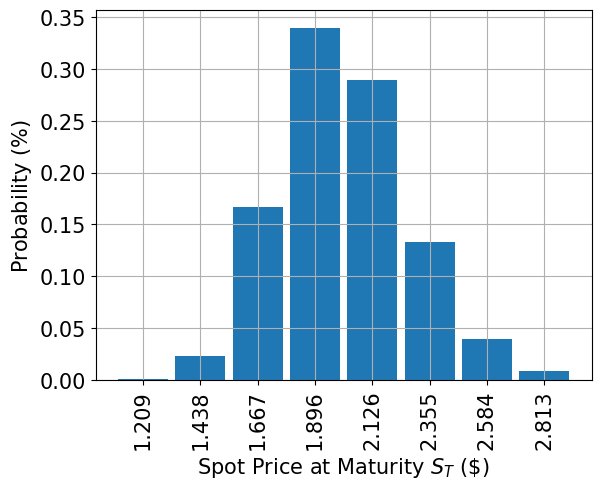

In [8]:
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [9]:
strike_price = 1.9

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

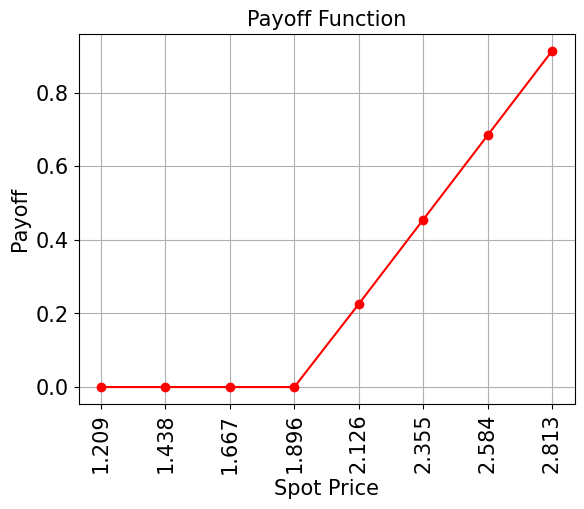

In [10]:
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [11]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1603
exact delta value:   	0.4700


In [12]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100, "seed": 75})
)

In [13]:
result = ae.estimate(problem)

: 